In [1]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
df = yf.download('AAPL', start='2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-31,72.482498,73.419998,72.379997,73.412498,72.039886,100805600
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.683571,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.967216,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.548630,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,73.202728,108872000
...,...,...,...,...,...,...
2022-10-25,150.089996,152.490005,149.360001,152.339996,152.339996,74732300
2022-10-26,150.960007,151.990005,148.039993,149.350006,149.350006,88194300
2022-10-27,148.070007,149.050003,144.130005,144.800003,144.800003,109180200


In [4]:
window = 25

In [5]:
test_df = df[:window]

In [7]:
test_df.shape

(25, 6)

In [33]:
test_df.iloc[-1].name

Timestamp('2020-02-05 00:00:00')

In [9]:
y_ = test_df.Close

In [15]:
X_ = pd.Series(range(len(test_df.index))).values

In [17]:
model_ = sm.OLS(y_, sm.add_constant(X_)).fit()

In [19]:
model_.params

const    75.230253
x1        0.224854
dtype: float64

In [23]:
75.230253 + 24 * 0.224854

80.626749

In [24]:
model_.predict()[-1]

80.62674783559945

In [28]:
df.shape[0] - 24

691

In [34]:
lsma_arr = []
dates_arr = []

for i in range(len(df) - 24):
    input_reg = df[i:25+i]
    X = pd.Series(range(len(input_reg.index))).values
    y = input_reg.Close
    model = sm.OLS(y, sm.add_constant(X)).fit()
    pred = model.predict()[-1]
    lsma_arr.append(pred)
    dates_arr.append(input_reg.iloc[-1].name)

In [36]:
lsma_df = pd.DataFrame({'LSMA':lsma_arr}, index=dates_arr)

In [37]:
lsma_df

,LSMA
2020-02-05,80.626748
2020-02-06,80.774163
2020-02-07,80.787501
2020-02-10,80.754316
2020-02-11,80.639746
...,...
2022-10-25,142.537231
2022-10-26,143.826155
2022-10-27,144.391018
2022-10-28,146.493787


In [39]:
all_df = pd.concat([lsma_df,df],axis=1)

In [42]:
all_df.dropna(inplace=True)

In [43]:
all_df

,LSMA,Open,High,Low,Close,Adj Close,Volume
2020-02-05,80.626748,80.879997,81.190002,79.737503,80.362503,78.859947,118826800
2020-02-06,80.774163,80.642502,81.305000,80.065002,81.302498,79.782356,105425600
2020-02-07,80.787501,80.592499,80.849998,79.500000,80.007500,78.697899,117684000
2020-02-10,80.754316,78.544998,80.387497,78.462502,80.387497,79.071686,109348800
2020-02-11,80.639746,80.900002,80.974998,79.677498,79.902496,78.594620,94323200
...,...,...,...,...,...,...,...
2022-10-25,142.537231,150.089996,152.490005,149.360001,152.339996,152.339996,74732300
2022-10-26,143.826155,150.960007,151.990005,148.039993,149.350006,149.350006,88194300
2022-10-27,144.391018,148.070007,149.050003,144.130005,144.800003,144.800003,109180200
2022-10-28,146.493787,148.199997,157.500000,147.820007,155.740005,155.740005,164659100


In [44]:
all_df['signal_buy'] = all_df.Close < all_df.LSMA
all_df['signal_sell'] = all_df.Close > all_df.LSMA

In [46]:
all_df['shifted_open'] = all_df.Open.shift(-1)

In [48]:
in_position = False

buydates,selldates = [],[]
buyprices,sellprices = [],[]


for index,row in all_df.iterrows():
    if not in_position and row.signal_buy == True:
        buyprice = row.shifted_open
        buyprices.append(buyprice)
        buydates.append(index)
        in_position = True
    if in_position and row.signal_sell == True:
        sellprice = row.shifted_open
        sellprices.append(sellprice)
        selldates.append(index)
        in_position = False

In [54]:
profits = pd.Series([(sell - buy)/buy for sell,buy in zip(sellprices,buyprices)])

In [55]:
(profits + 1).prod()

2.0533266575867155

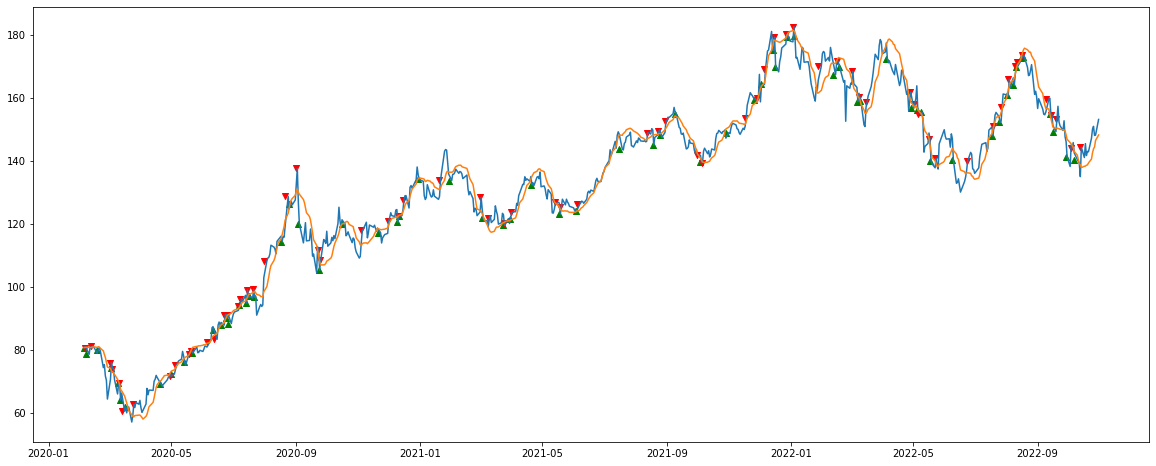

In [56]:
plt.figure(figsize=(20,8))
plt.plot(all_df[['Open','LSMA']])
plt.scatter(buydates, all_df.loc[buydates].shifted_open, marker='^', color='green')
plt.scatter(selldates, all_df.loc[selldates].shifted_open, marker='v', color='red')

In [57]:
(profits > 0).value_counts()

True     47
False    22
dtype: int64

In [59]:
47/(47+22)

0.6811594202898551

In [63]:
153.339996/80.362503 - 1

0.9081037831785803

In [60]:
all_df

,LSMA,Open,High,Low,Close,Adj Close,Volume,signal_buy,signal_sell,shifted_open
2020-02-05,80.626748,80.879997,81.190002,79.737503,80.362503,78.859947,118826800,True,False,80.642502
2020-02-06,80.774163,80.642502,81.305000,80.065002,81.302498,79.782356,105425600,False,True,80.592499
2020-02-07,80.787501,80.592499,80.849998,79.500000,80.007500,78.697899,117684000,True,False,78.544998
2020-02-10,80.754316,78.544998,80.387497,78.462502,80.387497,79.071686,109348800,True,False,80.900002
2020-02-11,80.639746,80.900002,80.974998,79.677498,79.902496,78.594620,94323200,True,False,80.367500
...,...,...,...,...,...,...,...,...,...,...
2022-10-25,142.537231,150.089996,152.490005,149.360001,152.339996,152.339996,74732300,False,True,150.960007
2022-10-26,143.826155,150.960007,151.990005,148.039993,149.350006,149.350006,88194300,False,True,148.070007
2022-10-27,144.391018,148.070007,149.050003,144.130005,144.800003,144.800003,109180200,False,True,148.199997
2022-10-28,146.493787,148.199997,157.500000,147.820007,155.740005,155.740005,164659100,False,True,153.160004
